## Cell2FireML examples (Real landscape -- Canada)

In [1]:
# Import
import os
import time
import glob 
import shutil
import signal
import subprocess
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio 

# Basic metrics
from numpy import linalg as LA
from sklearn.metrics import f1_score
from skimage.metrics import structural_similarity as ssim

# Needed to generate Data.csv for Cell2Fire
import utils.DataGeneratorC as DataGenerator

### Utils

In [10]:
# Utilities
# Print solutions from results folders
def print_grids_results_folders(folders):
    # Sort
    folders.sort()
    
    # Load and print
    for f in folders:
        grids = glob.glob(os.path.join(f, 'Grids', 'Grids1', '*.csv'))
        file = grids[0]

        # grid = np.loadtxt(file, delimiter=' ')
        grid = np.loadtxt(file, delimiter=',')

        # Plot
        plt.figure(1, figsize=(6,6)) 
        plt.imshow(grid)
        plt.title(f.split(os.path.sep)[-1])
        plt.show()
        time.sleep(0.1)
    
    # Return grid
    return grid
        
# Print solutions from prometheus
def print_grids_prometheus_folders(folders, filename='PromGrid7.txt', delimiter=' '):
    # Sort
    folders.sort()
    
    # Load and print
    for f in folders:
        grids = glob.glob(os.path.join(f, filename))
        file = grids[0]

        # Space delimiters
        grid = np.loadtxt(file, delimiter=delimiter)

        # Plot
        plt.figure(1, figsize=(6,6)) 
        plt.imshow(grid, cmap='Reds')
        plt.title(f.split(os.path.sep)[-1])
        plt.show()
        time.sleep(0.1)
    
    # Return grid
    return grid

### Execute Cell2Fire

In [11]:
# Turns a dictionary into a class
class Dict2Class(object):
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

# Pre-processing: Generate the Data.csv file for the C++ core
def generateDataC(args):
    dataName = os.path.join(args.InFolder, "Data.csv")
    if os.path.isfile(dataName) is False:
        print("Generating Data.csv File...")
        if args.BBO:
            print('Data with BBO factors support')
            DataGenerator.GenDataFile_BBO(args.InFolder)            
        else:
            DataGenerator.GenDataFile(args.InFolder)            
            
# Run C++ Sim 
def run(cell2fire_path, args, verbose=False):
    # Parse args for calling C++ via subprocess        
    # old: execArray=[os.path.join(os.getcwd(),'Cell2FireC/Cell2Fire'), 
    execArray=[os.path.join(cell2fire_path,'Cell2Fire'), 
               '--input-instance-folder', args.InFolder,
               '--output-folder', args.OutFolder if (args.OutFolder is not None) else '',
               '--ignitions' if (args.ignitions) else '',
               '--sim-years', str(args.sim_years),
               '--nsims', str(args.nsims),
               '--grids' if (args.grids) else '', 
               '--final-grid' if (args.finalGrid) else '',
               '--Fire-Period-Length', str(args.input_PeriodLen),
               '--output-messages' if (args.OutMessages) else '',
               '--weather', args.WeatherOpt,
               '--nweathers', str(args.nweathers),
               '--ROS-CV', str(args.ROS_CV),
               '--IgnitionRad', str(args.IgRadius), 
               '--seed', str(int(args.seed)),
               '--nthreads', str(int(args.nthreads)),
               '--ROS-Threshold', str(args.ROS_Threshold),
               '--HFI-Threshold', str(args.HFI_Threshold),
               '--HFactor', str(args.HFactor),
               '--BFactor', str(args.BFactor),
               '--FFactor', str(args.FFactor),
               '--EFactor', str(args.EFactor),
               '--bbo' if (args.BBO) else '',
               '--HarvestPlan', args.HCells if(args.HCells is not None) else '',
               '--verbose' if (args.verbose) else '',]

    # Print exec array
    if verbose:
        print('ExecArray:', ' '.join(execArray))
    
    # Output log
    if args.OutFolder is not None:
        if os.path.isdir(args.OutFolder) is False:
            os.makedirs(args.OutFolder)
        LogName = os.path.join(args.OutFolder, "LogFile.txt")
    else:
        LogName = os.path.join(args.InFolder, "LogFile.txt")   

    # Perform the call
    with open(LogName, 'w') as output:
        proc = subprocess.Popen(execArray, stdout=output)
        proc.communicate()
    return_code = proc.wait()
    if (return_code != 0):
        raise RuntimeError(f'C++ returned {return_code}.\nTry looking at {LogName}.') 

    # End of the replications
    print("End of Cell2FireC execution...")

In [12]:
# Globals
cell2fire_ml_canada = {}
prometheus_canada = {}

In [15]:
# Cell2Fire binary
BASE_PATH = '/home/minho/research/fire/c2f_codes/'
CELL2FIRE_PATH = os.path.join(BASE_PATH, 'Cell2FireC_Canada/')

# Input instance
INSTANCE_PATH = os.path.join(BASE_PATH, 'notebooks/data_canada/')
instance_name = 'dogrib'

# Results folder
OUT_PATH = os.path.join(BASE_PATH, '/notebooks/results_paper_canada/')

# Cell2Fire options
args = {
    'InFolder': INSTANCE_PATH + instance_name + '/',
    'OutFolder': OUT_PATH + instance_name + '/',
    'ignitions': True,
    'sim_years': 1,
    'nsims': 1,
    'grids': False, 
    'finalGrid': True,
    'input_PeriodLen': 1.0,
    'OutMessages': False,
    'WeatherOpt': 'rows',
    'nweathers': 1,
    'ROS_CV': 0.0,
    'IgRadius': 0, 
    'seed': 123,
    'ROS_Threshold':0.0,
    'HFI_Threshold':0.0,
    'HFactor':1.0,
    'BFactor':1.0,
    'FFactor':1.0,
    'EFactor':1.0,
    'nthreads':1,
    'BBO': False,
    'HCells': None,
    'verbose': False,
}

### (1) Without BBO fine-tuning

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_Canada/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/notebooks/data_canada/dogrib/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_canada/dogrib_no_tune/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.9  --HarvestPlan  
End of Cell2FireC execution...
Cell2FireML


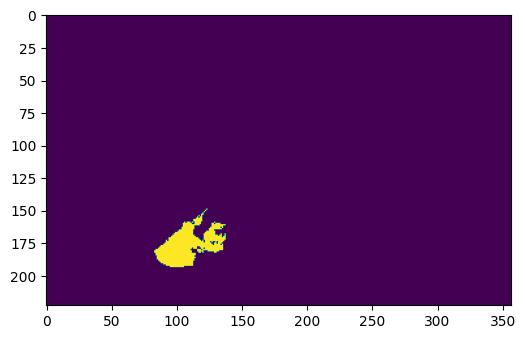

Prometheus


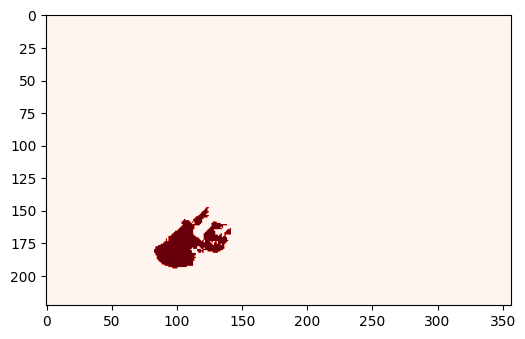

In [16]:
# Set new instance
out_name = 'dogrib_no_tune'

# Update parameters
args['InFolder'] = INSTANCE_PATH + instance_name + '/'
args['OutFolder'] = OUT_PATH + out_name + '/'
args['input_PeriodLen'] = 0.1
args['HFactor'] = 1.
args['FFactor'] = 1.0
args['BFactor'] = 1.0
args['EFactor'] = 0.9
args['BBO'] = False

# Convert to object
args_obj = Dict2Class(args)

# Generate data if needed
generateDataC(args_obj)
              
# Execution
run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)

# Outputs
print('Cell2FireML')
cell2fire_ml_canada[instance_name] = print_grids_results_folders([args_obj.OutFolder])

try:
    print('Prometheus')
    prometheus_canada[instance_name] = print_grids_prometheus_folders([args_obj.InFolder], filename='prometheus_dogrib.csv', delimiter=',')
except:
    print('No ground truth')

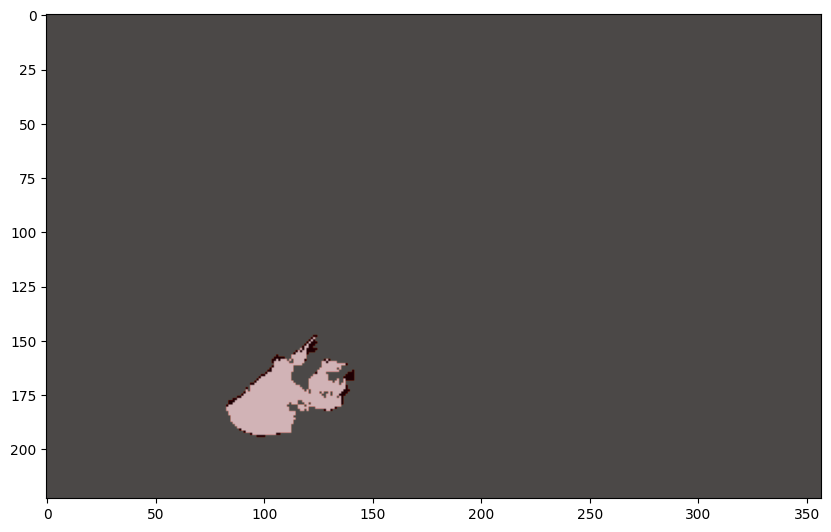

In [17]:
# Comparison
plt.figure(1,figsize=(10,10)) 
plt.imshow(cell2fire_ml_canada[instance_name], cmap='gray')
plt.imshow(prometheus_canada[instance_name], cmap='Reds', alpha=0.3)

#### (2) With BBO fine-tuning

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_Canada/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/notebooks/data_canada/dogrib/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_canada/dogrib_bbo/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.0 --bbo --HarvestPlan  
End of Cell2FireC execution...
Cell2FireML


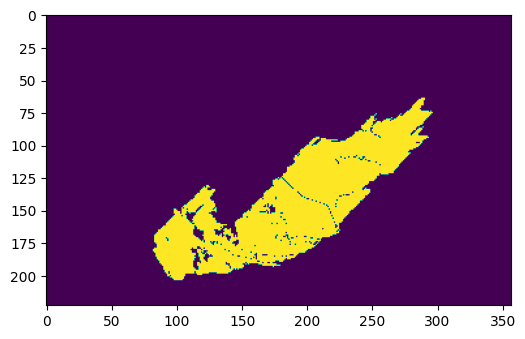

Prometheus


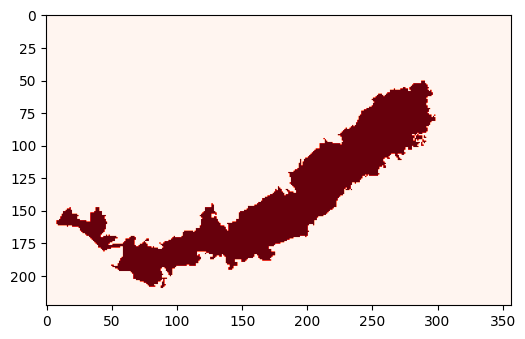

In [21]:
# Set new instance
out_name = 'dogrib_bbo'

# Update parameters
args['InFolder'] = INSTANCE_PATH + instance_name + '/'
args['OutFolder'] = OUT_PATH + out_name + '/'
args['input_PeriodLen'] = 0.1
args['HFactor'] = 1.0
args['FFactor'] = 1.0
args['BFactor'] = 1.0
args['EFactor'] = 1.0
args['BBO'] = True

# Convert to object
args_obj = Dict2Class(args)

# Generate data if needed
generateDataC(args_obj)
              
# Execution
run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)

# Outputs
print('Cell2FireML')
cell2fire_ml_canada[instance_name + '_BBO'] = print_grids_results_folders([args_obj.OutFolder])

try:
    print('Prometheus')
    prometheus_canada[instance_name + '_REAL'] = print_grids_prometheus_folders([args_obj.InFolder], filename='real_scar_dogrib.csv', delimiter=' ')
except:
    print('No ground truth')

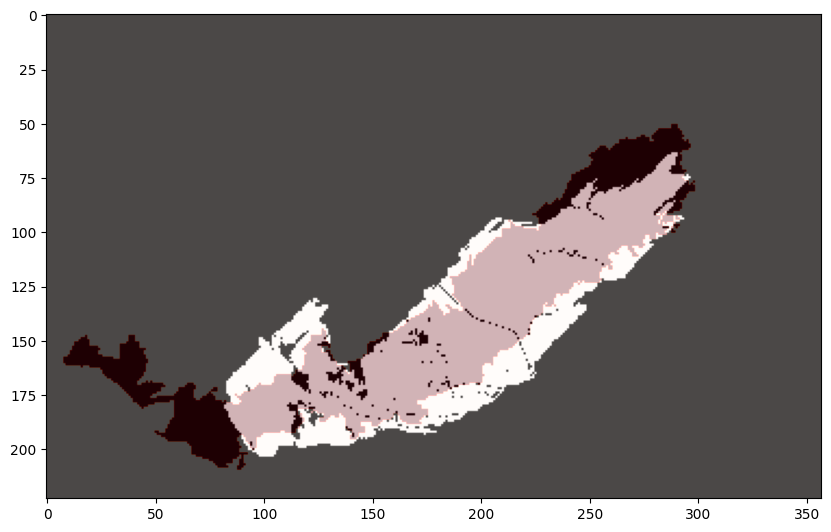

In [22]:
# Comparison
plt.figure(1,figsize=(10,10)) 
plt.imshow(cell2fire_ml_canada[instance_name + "_BBO"], cmap='gray')
plt.imshow(prometheus_canada[instance_name + "_REAL"], cmap='Reds', alpha=0.3)

#### Accuracy/error assessment

In [24]:
# Container Dogrib
df_results_dogrib = {}

In [25]:
# Metrics
instance = 'dogrib'
cell2fire = cell2fire_ml_canada[instance]
farsite = prometheus_canada[instance]
# cell2fire[cell2fire == 0] = np.nan
# farsite[farsite == 0] = np.nan

norm = LA.norm(cell2fire - farsite)
mse = ((cell2fire - farsite)**2).mean()
f1 = f1_score(farsite.flatten() , cell2fire.flatten(), average='macro')
ssim_sc = ssim(cell2fire, farsite, data_range=1)
area_cell2fire = len(cell2fire[cell2fire == 1])
area_farsite = len(farsite[farsite == 1])

# Results
df_results = pd.DataFrame({'Instance':[instance + '_short'],
                          '$\delta$ norm':[norm],
                          'MSE': [mse],
                          'F1': [f1],
                          'SSIM': [ssim_sc],
                          'AreaCell2FireML': [area_cell2fire],
                          'AreaPrometheus': [area_farsite],
                          }).round(3)
df_results_dogrib[instance] = df_results
df_results

<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1245008/1339613284.py:17: SyntaxWarning: invalid escape sequence '\d'
  '$\delta$ norm':[norm],


,Instance,$\delta$ norm,MSE,F1,SSIM,AreaCell2FireML,AreaPrometheus
0,dogrib_short,10.724,0.001,0.974,0.993,1082,1197


In [27]:
# Metrics
instance = 'dogrib'
cell2fire = cell2fire_ml_canada[instance + '_BBO']
farsite = prometheus_canada[instance + '_REAL']

norm = LA.norm(cell2fire - farsite)
mse = ((cell2fire - farsite)**2).mean()
f1 = f1_score(farsite.flatten() , cell2fire.flatten(), average='macro')
ssim_sc = ssim(cell2fire, farsite, data_range=1)
area_cell2fire = len(cell2fire[cell2fire == 1])
area_farsite = len(farsite[farsite == 1])

# Results
df_results = pd.DataFrame({'Instance':[instance + '_full_BBOvsReal'],
                          '$\delta$ norm':[norm],
                          'MSE': [mse],
                          'F1': [f1],
                          'SSIM': [ssim_sc],
                          'AreaCell2FireML': [area_cell2fire],
                          'AreaPrometheus': [area_farsite],
                          }).round(3)
df_results_dogrib[instance + '_BBOvsReal_Full'] = df_results
df_results

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1245008/3587878813.py:15: SyntaxWarning: invalid escape sequence '\d'
  '$\delta$ norm':[norm],


,Instance,$\delta$ norm,MSE,F1,SSIM,AreaCell2FireML,AreaPrometheus
0,dogrib_full_BBOvsReal,79.278,0.079,0.826,0.818,10503,10210


In [28]:
# Metrics
instance = 'dogrib'
cell2fire = cell2fire_ml_canada[instance]
farsite = prometheus_canada[instance + '_REAL']

norm = LA.norm(cell2fire - farsite)
mse = ((cell2fire - farsite)**2).mean()
f1 = f1_score(farsite.flatten() , cell2fire.flatten(), average='macro')
ssim_sc = ssim(cell2fire, farsite, data_range=1)
area_cell2fire = len(cell2fire[cell2fire == 1])
area_farsite = len(farsite[farsite == 1])

# Results
df_results = pd.DataFrame({'Instance':[instance + '_shortvsReal'],
                          '$\delta$ norm':[norm],
                          'MSE': [mse],
                          'F1': [f1],
                          'SSIM': [ssim_sc],
                          'AreaCell2FireML': [area_cell2fire],
                          'AreaPrometheus': [area_farsite],
                          }).round(3)
df_results_dogrib[instance + '_FBPvsReal'] = df_results
df_results

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1245008/235881398.py:15: SyntaxWarning: invalid escape sequence '\d'
  '$\delta$ norm':[norm],


,Instance,$\delta$ norm,MSE,F1,SSIM,AreaCell2FireML,AreaPrometheus
0,dogrib_shortvsReal,97.16,0.119,0.55,0.82,1082,10210


In [30]:
df_summary_dogrib = pd.concat([_ for _ in df_results_dogrib.values()], axis=0).reset_index(drop=True)
df_summary_dogrib

,Instance,$\delta$ norm,MSE,F1,SSIM,AreaCell2FireML,AreaPrometheus
0,dogrib_short,10.724,0.001,0.974,0.993,1082,1197
1,dogrib_full_BBOvsReal,79.278,0.079,0.826,0.818,10503,10210
2,dogrib_shortvsReal,97.160,0.119,0.550,0.820,1082,10210


In [31]:
df_summary_dogrib

,Instance,$\delta$ norm,MSE,F1,SSIM,AreaCell2FireML,AreaPrometheus
0,dogrib_short,10.724,0.001,0.974,0.993,1082,1197
1,dogrib_full_BBOvsReal,79.278,0.079,0.826,0.818,10503,10210
2,dogrib_shortvsReal,97.160,0.119,0.550,0.820,1082,10210


In [48]:
# df_summary_dogrib.to_csv(os.path.join(OUT_PATH, 'summary_results_canada_dogrib.csv'), index=False)